<a href="https://colab.research.google.com/github/Ananyadevaraju/CE888---Assignment-2/blob/main/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BIAS IN POLICING IN THE US: DETECTING AND MITIGATING DISPARATE IMPACT






Install packages:

In [1]:
# install necessary packages

!pip install aif360
!pip install fairlearn
!pip install BlackBoxAuditing

Import packages:

In [2]:
#import necessary packages

import pandas as pd
import numpy as np
from datetime import datetime 
#data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#label encoder
from sklearn.preprocessing import LabelEncoder
#train-test-split 
from sklearn.model_selection import train_test_split
#classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
#feature selection
from sklearn.feature_selection import RFE

#feature scaling
from sklearn.preprocessing import StandardScaler

#aif360
#fairness metrics
import aif360
from aif360.metrics import BinaryLabelDatasetMetric

#bias mitigation techniques
from aif360.algorithms.preprocessing import DisparateImpactRemover

# to evaluate model performance
from sklearn import metrics
from sklearn.metrics import accuracy_score

pd.set_option('display.max_rows',1000)

Load data:

This dataset is obtained from https://www1.nyc.gov/site/nypd/stats/reports-analysis/stopfrisk.page, which contains records of stop, question and frisk in 2019, from the NYPD database. The dataframe has 13,459 observations and infomration on 83 variables.

In [3]:
#load data 
df = pd.read_csv("https://raw.githubusercontent.com/Ananyadevaraju/CE888---Assignment-1/main/sqf-2019.csv")

In [4]:
#shape of the dataframe
df.shape

(13459, 83)

The dataset has 13459 rows or observations and 83 columns or features.

In [5]:
df.head()

,STOP_ID_ANONY,STOP_FRISK_DATE,STOP_FRISK_TIME,YEAR2,MONTH2,DAY2,STOP_WAS_INITIATED,RECORD_STATUS_CODE,ISSUING_OFFICER_RANK,ISSUING_OFFICER_COMMAND_CODE,SUPERVISING_OFFICER_RANK,SUPERVISING_OFFICER_COMMAND_CODE,LOCATION_IN_OUT_CODE,JURISDICTION_CODE,JURISDICTION_DESCRIPTION,OBSERVED_DURATION_MINUTES,SUSPECTED_CRIME_DESCRIPTION,STOP_DURATION_MINUTES,OFFICER_EXPLAINED_STOP_FLAG,OFFICER_NOT_EXPLAINED_STOP_DESCRIPTION,OTHER_PERSON_STOPPED_FLAG,SUSPECT_ARRESTED_FLAG,SUSPECT_ARREST_OFFENSE,SUMMONS_ISSUED_FLAG,SUMMONS_OFFENSE_DESCRIPTION,OFFICER_IN_UNIFORM_FLAG,ID_CARD_IDENTIFIES_OFFICER_FLAG,SHIELD_IDENTIFIES_OFFICER_FLAG,VERBAL_IDENTIFIES_OFFICER_FLAG,FRISKED_FLAG,SEARCHED_FLAG,ASK_FOR_CONSENT_FLG,CONSENT_GIVEN_FLG,OTHER_CONTRABAND_FLAG,FIREARM_FLAG,KNIFE_CUTTER_FLAG,OTHER_WEAPON_FLAG,WEAPON_FOUND_FLAG,PHYSICAL_FORCE_CEW_FLAG,PHYSICAL_FORCE_DRAW_POINT_FIREARM_FLAG,...,PHYSICAL_FORCE_RESTRAINT_USED_FLAG,PHYSICAL_FORCE_VERBAL_INSTRUCTION_FLAG,PHYSICAL_FORCE_WEAPON_IMPACT_FLAG,BACKROUND_CIRCUMSTANCES_VIOLENT_CRIME_FLAG,BACKROUND_CIRCUMSTANCES_SUSPECT_KNOWN_TO_CARRY_WEAPON_FLAG,SUSPECTS_ACTIONS_CASING_FLAG,SUSPECTS_ACTIONS_CONCEALED_POSSESSION_WEAPON_FLAG,SUSPECTS_ACTIONS_DECRIPTION_FLAG,SUSPECTS_ACTIONS_DRUG_TRANSACTIONS_FLAG,SUSPECTS_ACTIONS_IDENTIFY_CRIME_PATTERN_FLAG,SUSPECTS_ACTIONS_LOOKOUT_FLAG,SUSPECTS_ACTIONS_OTHER_FLAG,SUSPECTS_ACTIONS_PROXIMITY_TO_SCENE_FLAG,SEARCH_BASIS_ADMISSION_FLAG,SEARCH_BASIS_CONSENT_FLAG,SEARCH_BASIS_HARD_OBJECT_FLAG,SEARCH_BASIS_INCIDENTAL_TO_ARREST_FLAG,SEARCH_BASIS_OTHER_FLAG,SEARCH_BASIS_OUTLINE_FLAG,DEMEANOR_CODE,DEMEANOR_OF_PERSON_STOPPED,SUSPECT_REPORTED_AGE,SUSPECT_SEX,SUSPECT_RACE_DESCRIPTION,SUSPECT_HEIGHT,SUSPECT_WEIGHT,SUSPECT_BODY_BUILD_TYPE,SUSPECT_EYE_COLOR,SUSPECT_HAIR_COLOR,SUSPECT_OTHER_DESCRIPTION,STOP_LOCATION_PRECINCT,STOP_LOCATION_SECTOR_CODE,STOP_LOCATION_APARTMENT,STOP_LOCATION_FULL_ADDRESS,STOP_LOCATION_STREET_NAME,STOP_LOCATION_X,STOP_LOCATION_Y,STOP_LOCATION_ZIP_CODE,STOP_LOCATION_PATROL_BORO_NAME,STOP_LOCATION_BORO_NAME
0,1,02-01-2019,14:30:00,2019,January,Wednesday,Based on C/W on Scene,APP,POM,1,SGT,1,I,P,PSB,1,PETIT LARCENY,10,Y,(null),N,N,(null),N,(null),Y,(null),(null),(null),Y,N,Y,Y,N,(null),(null),(null),N,(null),(null),...,(null),(,(null),(null),(null),(null),(null),(null),(null),(null),(null),Y,(null),(null),(null),(null),(null),(null),(null),DE,UNDERSTANDING,30,MALE,BLACK,5.11,230,HEA,BRO,BLK,UNKNOWN,1,C,(null),230 VESEY STREET,VESEY STREET,979667,199737,(null),PBMS,MANHATTAN
1,2,08-01-2019,02:30:00,2019,January,Tuesday,Based on Self Initiated,APP,POM,1,SGT,1,O,P,PSB,1,GRAND LARCENY,10,Y,(null),N,Y,GRAND LARCENY,N,(null),N,(null),S,V,N,Y,N,N,N,(null),(null),(null),N,(null),(null),...,(null),Y,(null),(null),(null),(null),(null),(null),(null),(null),(null),Y,(null),(null),(null),(null),Y,(null),(null),DE,NORMAL,22,MALE,BLACK,5.1,190,MED,BRO,BLK,(null),1,C,(null),9 WHITE STREET,WHITE STREET,982650,201326,(null),PBMS,MANHATTAN
2,3,12-01-2019,16:54:00,2019,January,Saturday,Based on Radio Run,APP,POM,1,SGT,1,I,P,PSB,1,PETIT LARCENY,4,Y,(null),N,Y,PETIT LARCENY,N,(null),Y,(null),(null),(null),N,N,N,(,N,(null),(null),(null),N,(null),(null),...,(null),Y,(null),(null),(null),(null),(null),Y,(null),(null),(null),(null),Y,(null),(null),(null),(null),(null),(null),DE,CALM,56,MALE,WHITE,5.9,250,HEA,BLU,BLK,"BLACK LONG COAT, BLACK PANTS, BLACK FEDORA HAT...",1,D,(null),131 SPRING STREET,SPRING STREET,984063,203033,(null),PBMS,MANHATTAN
3,4,14-01-2019,21:21:00,2019,January,Monday,Based on Radio Run,APP,POM,1,SGT,1,O,P,PSB,0,ROBBERY,5,Y,(null),N,N,(null),N,(null),Y,(null),(null),(null),N,N,N,N,N,(null),(null),(null),N,(null),(null),...,(null),Y,(null),(null),(null),(null),(null),Y,(null),(null),(null),(null),Y,(null),(null),(null),(null),(null),(null),DE,CONFUSED,(null),MALE,BLACK,,,(null),(null),(null),(null),1,(,(null),GRAND STREET && 6TH AVE,GRAND STREET,982848,202677,(null),PBMS,MANHATTAN
4,5,15-01-2019,18:50:00,2019,January,Tuesday,Based on Radio Run,APP,POM,1,SGT,1,O,P,PSB,1,

In [6]:
#columns names in the dataframe
df.columns

Index(['STOP_ID_ANONY', 'STOP_FRISK_DATE', 'STOP_FRISK_TIME', 'YEAR2',
       'MONTH2', 'DAY2', 'STOP_WAS_INITIATED', 'RECORD_STATUS_CODE',
       'ISSUING_OFFICER_RANK', 'ISSUING_OFFICER_COMMAND_CODE',
       'SUPERVISING_OFFICER_RANK', 'SUPERVISING_OFFICER_COMMAND_CODE',
       'LOCATION_IN_OUT_CODE', 'JURISDICTION_CODE', 'JURISDICTION_DESCRIPTION',
       'OBSERVED_DURATION_MINUTES', 'SUSPECTED_CRIME_DESCRIPTION',
       'STOP_DURATION_MINUTES', 'OFFICER_EXPLAINED_STOP_FLAG',
       'OFFICER_NOT_EXPLAINED_STOP_DESCRIPTION', 'OTHER_PERSON_STOPPED_FLAG',
       'SUSPECT_ARRESTED_FLAG', 'SUSPECT_ARREST_OFFENSE',
       'SUMMONS_ISSUED_FLAG', 'SUMMONS_OFFENSE_DESCRIPTION',
       'OFFICER_IN_UNIFORM_FLAG', 'ID_CARD_IDENTIFIES_OFFICER_FLAG',
       'SHIELD_IDENTIFIES_OFFICER_FLAG', 'VERBAL_IDENTIFIES_OFFICER_FLAG',
       'FRISKED_FLAG', 'SEARCHED_FLAG', 'ASK_FOR_CONSENT_FLG',
       'CONSENT_GIVEN_FLG', 'OTHER_CONTRABAND_FLAG', 'FIREARM_FLAG',
       'KNIFE_CUTTER_FLAG', 'OTHER_WEAPON_F

In [7]:
#information on count, missing data and datatype of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13459 entries, 0 to 13458
Data columns (total 83 columns):
 #   Column                                                      Non-Null Count  Dtype 
---  ------                                                      --------------  ----- 
 0   STOP_ID_ANONY                                               13459 non-null  int64 
 1   STOP_FRISK_DATE                                             13459 non-null  object
 2   STOP_FRISK_TIME                                             13459 non-null  object
 3   YEAR2                                                       13459 non-null  int64 
 4   MONTH2                                                      13459 non-null  object
 5   DAY2                                                        13459 non-null  object
 6   STOP_WAS_INITIATED                                          13459 non-null  object
 7   RECORD_STATUS_CODE                                          13459 non-null  object
 8   ISSUIN

Missing data:

In [8]:
#checking for number of NaN values in each column
df.isnull().sum()

STOP_ID_ANONY                                                    0
STOP_FRISK_DATE                                                  0
STOP_FRISK_TIME                                                  0
YEAR2                                                            0
MONTH2                                                           0
DAY2                                                             0
STOP_WAS_INITIATED                                               0
RECORD_STATUS_CODE                                               0
ISSUING_OFFICER_RANK                                             0
ISSUING_OFFICER_COMMAND_CODE                                     0
SUPERVISING_OFFICER_RANK                                         0
SUPERVISING_OFFICER_COMMAND_CODE                                 0
LOCATION_IN_OUT_CODE                                             0
JURISDICTION_CODE                                                0
JURISDICTION_DESCRIPTION                                      

Data transformation:

In [9]:
#create a copy of the original data before making any changes in it
stop_search_df = df.copy()

In [10]:
#gender feature - count of each class, male and female
stop_search_df["SUSPECT_SEX"].value_counts()

MALE      12179
FEMALE     1230
(null)       50
Name: SUSPECT_SEX, dtype: int64

In [11]:
#drop null values from "SUSPECT SEX"
stop_search_df = stop_search_df[stop_search_df["SUSPECT_SEX"] != "(null)"]

In [12]:
#value counts of different races stopped 
stop_search_df["SUSPECT_RACE_DESCRIPTION"].value_counts() 

BLACK                        7966
WHITE HISPANIC               2739
WHITE                        1213
BLACK HISPANIC               1125
ASIAN / PACIFIC ISLANDER      300
(null)                         58
AMERICAN INDIAN/ALASKAN N       8
Name: SUSPECT_RACE_DESCRIPTION, dtype: int64

In [13]:
#drop the rows with "SUSPECT_RACE_DESCRIPTION" as "(null)"
#select only the rows which have specified race
stop_search_df = stop_search_df[stop_search_df["SUSPECT_RACE_DESCRIPTION"] != "(null)"]

#converting all classes other than Whites as Non-Whites - creating binary sensitive variable

race = []
for x in stop_search_df["SUSPECT_RACE_DESCRIPTION"]:
  if x == "WHITE":
    y = "White"  
  else:
    y = "Non-White"     
  race.append(y)       
  
stop_search_df["RACE"] = race              

#value_counts
stop_search_df["RACE"].value_counts() 

Non-White    12138
White         1213
Name: RACE, dtype: int64

In [14]:
###########
#extracting hour from time column
stop_search_df["Parts_of_day"] = pd.to_datetime(stop_search_df["STOP_FRISK_TIME"], format = "%H:%M:%S").dt.hour
#converting into day or night

# converting time into parts of day
Parts_of_day = []
for t in stop_search_df["Parts_of_day"]:
  if t >= 6 and t < 18:
    part = "Day"
  else:
    part = "Night"
  Parts_of_day.append(part)  

#adding new column "Parts_of_day" to the dataframe
stop_search_df["Parts_of_day"] = Parts_of_day

#value counts
stop_search_df["Parts_of_day"].value_counts()

Night    7815
Day      5536
Name: Parts_of_day, dtype: int64

In [15]:
#replace "(" with "(null)" in the entire data
stop_search_df.replace(to_replace = "(", value = "(null)", inplace = True)

In [16]:
#drop the "(null)" values in "SUSPECT_REPORTED_AGE"
stop_search_df = stop_search_df[stop_search_df["SUSPECT_REPORTED_AGE"] != "(null)"]

Investigating and dropping redundant columns:
The dataset contains 83 columns and most of the features are categorical. After preprocessing using one-hot encoding, the number of columns in the data would increase further (in the further steps, after preprocessing, the number of columns were found to be about 2000 without removing redunant columns), which is a large number of columns for a structured and labelled dataset. Hence, it is important to carefully investigate and remove the redunant and irrelevant columns for the study, and columns with inconsistent data (with the help of some domain knowledge), before feature selection.

In [17]:
df["YEAR2"].value_counts()
#there is only one category in the column for all the observations
#hence can be dropped

2019    13459
Name: YEAR2, dtype: int64

In [18]:
df["RECORD_STATUS_CODE"].value_counts()
#there is only one category in the column for all the observations
#hence can be dropped

APP    13459
Name: RECORD_STATUS_CODE, dtype: int64

In [19]:
df["PHYSICAL_FORCE_RESTRAINT_USED_FLAG"].value_counts()
#there is only one category/class in the column for all the observations
#hence can be dropped 

(null)    13459
Name: PHYSICAL_FORCE_RESTRAINT_USED_FLAG, dtype: int64

In [20]:
##dropping redundant columns (example: code and its description for a feature)
# columns "JURISDICTION_CODE" and "DEMEANOR_CODE"

##there are several columns with information on location of the stop
#we are going to retain only the STOP_LOCATION_X, STOP_LOCATION_Y and STOP_LOCATION_BORO_NAME drop the rest of the columns on location

In [21]:
#drop columns
stop_search_df = stop_search_df.drop(columns = ["STOP_ID_ANONY", "STOP_FRISK_DATE", "STOP_FRISK_TIME", "YEAR2", "MONTH2", "RECORD_STATUS_CODE", "ISSUING_OFFICER_RANK", "SUPERVISING_OFFICER_RANK", "SUPERVISING_OFFICER_COMMAND_CODE", "JURISDICTION_CODE",
                                  "OTHER_PERSON_STOPPED_FLAG", "SUMMONS_ISSUED_FLAG", "ID_CARD_IDENTIFIES_OFFICER_FLAG", "SHIELD_IDENTIFIES_OFFICER_FLAG", "VERBAL_IDENTIFIES_OFFICER_FLAG", "FIREARM_FLAG", "KNIFE_CUTTER_FLAG", "OTHER_WEAPON_FLAG", 
                                  "PHYSICAL_FORCE_CEW_FLAG", "PHYSICAL_FORCE_DRAW_POINT_FIREARM_FLAG", "PHYSICAL_FORCE_OC_SPRAY_USED_FLAG", "PHYSICAL_FORCE_OTHER_FLAG", "PHYSICAL_FORCE_VERBAL_INSTRUCTION_FLAG", "PHYSICAL_FORCE_WEAPON_IMPACT_FLAG", 
                                  "SUSPECTS_ACTIONS_LOOKOUT_FLAG", "SUSPECTS_ACTIONS_OTHER_FLAG", "SEARCH_BASIS_OTHER_FLAG", "SEARCH_BASIS_OUTLINE_FLAG", "DEMEANOR_CODE", "DEMEANOR_OF_PERSON_STOPPED", "SUSPECT_HEIGHT","SUSPECT_WEIGHT","SUSPECT_EYE_COLOR","SUSPECT_OTHER_DESCRIPTION", "STOP_LOCATION_PRECINCT",
                                  "STOP_LOCATION_SECTOR_CODE", "STOP_LOCATION_APARTMENT", "STOP_LOCATION_FULL_ADDRESS", "STOP_LOCATION_STREET_NAME", "STOP_LOCATION_ZIP_CODE",
                                  "STOP_LOCATION_PATROL_BORO_NAME"], axis = 1)

Is the data imbalanced?


In [22]:
#arrest feature count of each class
stop_search_df["SUSPECT_ARRESTED_FLAG"].value_counts()

N    8141
Y    4166
Name: SUSPECT_ARRESTED_FLAG, dtype: int64

In [23]:
#calculating imbalance in the data
total_y = len(stop_search_df["SUSPECT_ARRESTED_FLAG"])

class_0 = (stop_search_df["SUSPECT_ARRESTED_FLAG"] == "Y").sum()
class_1 = (stop_search_df["SUSPECT_ARRESTED_FLAG"] == "N").sum()

#imbalance in classes
percentage_class_0 = (class_0/total_y)*100
print("Percentage of observations belonging to class Y (Arrested) = " , percentage_class_0)

percentage_class_1 = (class_1/total_y)*100
print("Percentage of observations belonging to class N (Not Arrested) = " , percentage_class_1)

Percentage of observations belonging to class Y (Arrested) =  33.85065409929309
Percentage of observations belonging to class N (Not Arrested) =  66.14934590070692


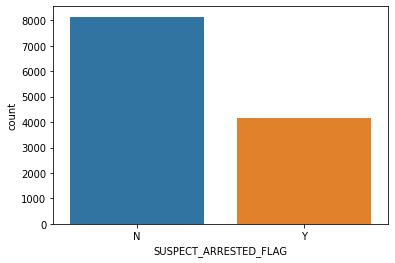

In [24]:
#imbalance in data
sns.countplot(x = "SUSPECT_ARRESTED_FLAG", data = stop_search_df)

Exploratory data analysis:




In [25]:
#does the data suggest racial bias?
#racial distribution of subjects stopped
stop_search_df["RACE"].value_counts()

Non-White    11153
White         1154
Name: RACE, dtype: int64

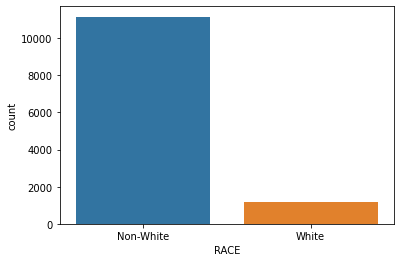

In [26]:
#racial distribution of subjects stopped
sns.countplot(x = "RACE", data = stop_search_df)

91% of non-whites were stopped, in contrast to 9% of whites.

In [27]:
#does the data suggest gender bias?
stop_search_df["SUSPECT_SEX"].value_counts()

MALE      11184
FEMALE     1123
Name: SUSPECT_SEX, dtype: int64

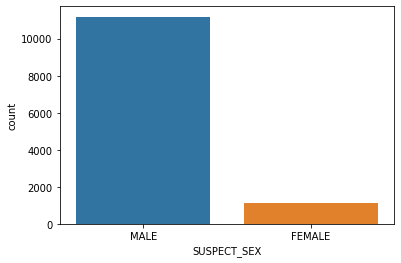

In [28]:
#count of different genders stopped (in the data)
sns.countplot(x="SUSPECT_SEX", data=stop_search_df)

91% and 9% of the subjects stopped were male and female, respectively.

Suspect arrested data:

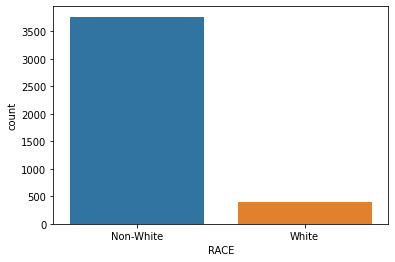

In [29]:
#racial distribution of the subjects searched
arrested_df = stop_search_df[stop_search_df["SUSPECT_ARRESTED_FLAG"] == "Y"]
sns.countplot(x = "RACE", data = arrested_df)

In [30]:
arrested_df["RACE"].value_counts()

Non-White    3764
White         402
Name: RACE, dtype: int64

32% of non-whites stopped and 34% of the whites stopped were searched.

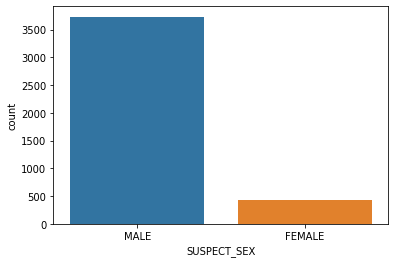

In [31]:
#gender distribution of the subjects arrested
sns.countplot(x = "SUSPECT_SEX", data = arrested_df)

In [32]:
arrested_df["SUSPECT_SEX"].value_counts()

MALE      3729
FEMALE     437
Name: SUSPECT_SEX, dtype: int64

32% of male subjects and 36% of female subjects were arrested.

Frisked data:

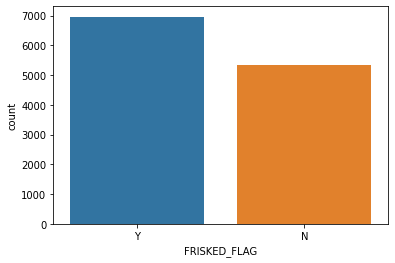

In [33]:
#frisk data
sns.countplot(x = "FRISKED_FLAG", data = stop_search_df)

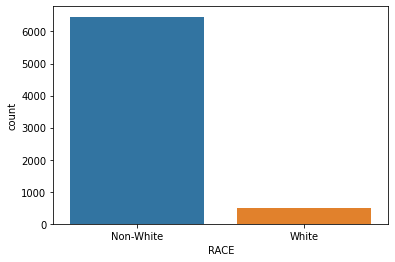

In [34]:
#racial distribution of subjects frisked
frisked_df = stop_search_df[stop_search_df["FRISKED_FLAG"] == "Y"]
sns.countplot(x = "RACE", data = frisked_df)

In [35]:
frisked_df["RACE"].value_counts()

Non-White    6460
White         504
Name: RACE, dtype: int64

58% of non-whites were frisked; 43% of whites were frisked.

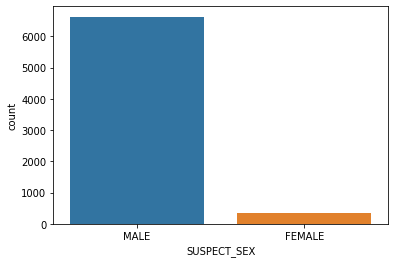

In [36]:
#gender distribution of subjects frisked
sns.countplot(x = "SUSPECT_SEX", data = frisked_df)

59% of male and 30% of female were frisked.

Data Preprocessing:

In [37]:
stop_search_df.tail()

,DAY2,STOP_WAS_INITIATED,ISSUING_OFFICER_COMMAND_CODE,LOCATION_IN_OUT_CODE,JURISDICTION_DESCRIPTION,OBSERVED_DURATION_MINUTES,SUSPECTED_CRIME_DESCRIPTION,STOP_DURATION_MINUTES,OFFICER_EXPLAINED_STOP_FLAG,OFFICER_NOT_EXPLAINED_STOP_DESCRIPTION,SUSPECT_ARRESTED_FLAG,SUSPECT_ARREST_OFFENSE,SUMMONS_OFFENSE_DESCRIPTION,OFFICER_IN_UNIFORM_FLAG,FRISKED_FLAG,SEARCHED_FLAG,ASK_FOR_CONSENT_FLG,CONSENT_GIVEN_FLG,OTHER_CONTRABAND_FLAG,WEAPON_FOUND_FLAG,PHYSICAL_FORCE_HANDCUFF_SUSPECT_FLAG,PHYSICAL_FORCE_RESTRAINT_USED_FLAG,BACKROUND_CIRCUMSTANCES_VIOLENT_CRIME_FLAG,BACKROUND_CIRCUMSTANCES_SUSPECT_KNOWN_TO_CARRY_WEAPON_FLAG,SUSPECTS_ACTIONS_CASING_FLAG,SUSPECTS_ACTIONS_CONCEALED_POSSESSION_WEAPON_FLAG,SUSPECTS_ACTIONS_DECRIPTION_FLAG,SUSPECTS_ACTIONS_DRUG_TRANSACTIONS_FLAG,SUSPECTS_ACTIONS_IDENTIFY_CRIME_PATTERN_FLAG,SUSPECTS_ACTIONS_PROXIMITY_TO_SCENE_FLAG,SEARCH_BASIS_ADMISSION_FLAG,SEARCH_BASIS_CONSENT_FLAG,SEARCH_BASIS_HARD_OBJECT_FLAG,SEARCH_BASIS_INCIDENTAL_TO_ARREST_FLAG,SUSPECT_REPORTED_AGE,SUSPECT_SEX,SUSPECT_RACE_DESCRIPTION,SUSPECT_BODY_BUILD_TYPE,SUSPECT_HAIR_COLOR,STOP_LOCATION_X,STOP_LOCATION_Y,STOP_LOCATION_BORO_NAME,RACE,Parts_of_day
13454,Monday,Based on Self Initiated,103,O,PSB,1,CRIMINAL POSSESSION OF CONTROLLED SUBSTANCE,2,Y,(null),Y,CRIMINAL POSSESSION OF CONTROLLE,(null),Y,N,N,N,N,Y,N,(null),(null),(null),(null),(null),(null),(null),(null),(null),(null),(null),(null),(null),(null),27,MALE,WHITE,THN,BLK,1037778,194006,QUEENS,White,Day
13455,Monday,Based on Self Initiated,107,(null),PSB,10,BURGLARY,8,Y,(null),N,(null),(null),Y,Y,N,N,N,N,N,(null),(null),Y,(null),Y,(null),(null),(null),Y,(null),(null),(null),(null),(null),40,MALE,BLACK,THN,GRY,1033722,205506,QUEENS,Non-White,Night
13456,Monday,Based on Radio Run,109,(null),PSB,1,ASSAULT,10,Y,(null),Y,ASSAULT,(null),Y,Y,Y,N,N,N,Y,(null),(null),Y,(null),(null),(null),Y,(null),(null),(null),(null),(null),Y,(null),55,MALE,WHITE,MED,GRY,1026950,225017,QUEENS,White,Day
13457,Saturday,Based on Radio Run,109,O,PSB,2,BURGLARY,5,Y,(null),Y,BURGLARY,(null),N,N,Y,N,N,N,N,(null),(null),(null),(null),(null),(null),Y,(null),(null),(null),(null),(null),(null),Y,54,MALE,ASIAN / PACIFIC ISLANDER,THN,BLD,1030630,213662,QUEENS,Non-White,Night
13458,Friday,Based on Radio Run,113,(null),PSB,1,OTHER,1,Y,(null),Y,OTHER,(null),Y,N,N,N,N,N,N,Y,(null),(null),(null),(null),(null),(null),(null),(null),Y,(null),(null),(null),(null),25,MALE,BLACK,MED,BLK,1042383,189913,QUEENS,Non-White,Day


In [38]:
#encoding the gender and race features manually
stop_search_df.loc[stop_search_df.SUSPECT_SEX == "FEMALE", "SUSPECT_SEX"] = 1
stop_search_df.loc[stop_search_df.SUSPECT_SEX == "MALE", "SUSPECT_SEX"] = 0

stop_search_df.loc[stop_search_df.RACE == "White", "RACE"] = 1
stop_search_df.loc[stop_search_df.RACE == "Non-White", "RACE"] = 0

#encoding the target column
stop_search_df.loc[stop_search_df.SEARCHED_FLAG == "Y", "SUSPECT_ARRESTED_FLAG"] = 0
stop_search_df.loc[stop_search_df.SEARCHED_FLAG == "N", "SUSPECT_ARRESTED_FLAG"] = 1


In [39]:
#target column
y = stop_search_df["SUSPECT_ARRESTED_FLAG"]

In [40]:
#feature scaling

#numerical features
numerical_features = ["ISSUING_OFFICER_COMMAND_CODE", "OBSERVED_DURATION_MINUTES", "STOP_DURATION_MINUTES", 
                      "SUSPECT_REPORTED_AGE", "STOP_LOCATION_X", "STOP_LOCATION_Y"]

#scaler = StandardScaler()
#stop_search_df[numerical_features] = scaler.fit_transform(stop_search_df[numerical_features])


In [41]:
stop_search_df.shape

(12307, 44)

In [42]:

#feature columns
#all the columns except for the target column
#x = stop_search_df[stop_search_df.columns.difference(["FRISKED_FLAG"])]


#categorical features
#list of all the columns other than numerical features
categorical_df = stop_search_df[stop_search_df.columns.difference(numerical_features)]
categorical_df = categorical_df[categorical_df.columns.difference(["SUSPECT_SEX","RACE","SUSPECT_ARRESTED_FLAG"])]
categorical_columns = categorical_df.columns.to_list()

#one-hot encoding categorical input variables
#x_df = pd.get_dummies(x)
for column in categorical_columns:
    encode = pd.get_dummies(stop_search_df[column], prefix = column)
    stop_search_df = stop_search_df.drop(column, axis = 1)
    stop_search_df = stop_search_df.join(encode)

In [43]:
stop_search_df.shape

(12307, 327)

In [44]:
x = stop_search_df.drop(['SUSPECT_ARRESTED_FLAG'], axis = 1)

In [45]:
y = y.astype('int')

In [46]:
# train-test split 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [47]:
##feature selection
classifier = RandomForestClassifier()

In [48]:
#y_train = y_train.astype('int')

In [49]:
from sklearn.feature_selection import RFE

rfe = RFE(classifier, 10)             # running RFE with 12 variables as output
rfe = rfe.fit(x_train, y_train)

In [50]:
rfe.support_

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [51]:
#leads_x_train_df = pd.DataFrame(x_train, columns = [leads_categorical_columns + leads_numerical_columns])

list(zip(x_train.columns, rfe.support_, rfe.ranking_))

[('ISSUING_OFFICER_COMMAND_CODE', False, 12),
 ('OBSERVED_DURATION_MINUTES', False, 20),
 ('STOP_DURATION_MINUTES', False, 14),
 ('SUSPECT_REPORTED_AGE', False, 15),
 ('SUSPECT_SEX', False, 57),
 ('STOP_LOCATION_X', False, 11),
 ('STOP_LOCATION_Y', False, 6),
 ('RACE', False, 72),
 ('ASK_FOR_CONSENT_FLG_(null)', False, 79),
 ('ASK_FOR_CONSENT_FLG_N', False, 13),
 ('ASK_FOR_CONSENT_FLG_Y', False, 16),
 ('BACKROUND_CIRCUMSTANCES_SUSPECT_KNOWN_TO_CARRY_WEAPON_FLAG_(null)',
  False,
  82),
 ('BACKROUND_CIRCUMSTANCES_SUSPECT_KNOWN_TO_CARRY_WEAPON_FLAG_Y', False, 88),
 ('BACKROUND_CIRCUMSTANCES_VIOLENT_CRIME_FLAG_(null)', False, 23),
 ('BACKROUND_CIRCUMSTANCES_VIOLENT_CRIME_FLAG_Y', False, 33),
 ('CONSENT_GIVEN_FLG_(null)', False, 42),
 ('CONSENT_GIVEN_FLG_N', False, 9),
 ('CONSENT_GIVEN_FLG_Y', False, 8),
 ('DAY2_Friday', False, 37),
 ('DAY2_Monday', False, 68),
 ('DAY2_Saturday', False, 59),
 ('DAY2_Sunday', False, 66),
 ('DAY2_Thursday', False, 45),
 ('DAY2_Tuesday', False, 54),
 ('DAY2_W

In [52]:
#encoded_df = stop_search_df[["SUSPECT_REPORTED_AGE", "STOP_LOCATION_X", "STOP_LOCATION_Y", "SEARCH_BASIS_CONSENT_FLAG_(null)", "SEARCH_BASIS_CONSENT_FLAG_Y", "SEARCH_BASIS_HARD_OBJECT_FLAG_(null)", "SEARCH_BASIS_HARD_OBJECT_FLAG_Y","SEARCH_BASIS_INCIDENTAL_TO_ARREST_FLAG_(null)", 
 #                        "SEARCH_BASIS_INCIDENTAL_TO_ARREST_FLAG_Y","WEAPON_FOUND_FLAG_N", "SUSPECT_SEX","RACE", "SEARCHED_FLAG"]]

#x = stop_search_df[["SUSPECT_REPORTED_AGE", "STOP_LOCATION_X", "STOP_LOCATION_Y", "SEARCH_BASIS_CONSENT_FLAG_(null)", "SEARCH_BASIS_CONSENT_FLAG_Y", "SEARCH_BASIS_HARD_OBJECT_FLAG_(null)", "SEARCH_BASIS_HARD_OBJECT_FLAG_Y","SEARCH_BASIS_INCIDENTAL_TO_ARREST_FLAG_(null)", 
 #                        "SEARCH_BASIS_INCIDENTAL_TO_ARREST_FLAG_Y","WEAPON_FOUND_FLAG_N", "SUSPECT_SEX","RACE", "SEARCHED_FLAG"]]

In [53]:
#encoded_df = stop_search_df[["SEARCHED_FLAG_N", "SEARCHED_FLAG_Y", "SEARCH_BASIS_ADMISSION_FLAG_Y", "SEARCH_BASIS_CONSENT_FLAG_(null)", "SEARCH_BASIS_CONSENT_FLAG_Y", 
    #                         "SEARCH_BASIS_HARD_OBJECT_FLAG_Y", "SEARCH_BASIS_INCIDENTAL_TO_ARREST_FLAG_(null)", "SEARCH_BASIS_INCIDENTAL_TO_ARREST_FLAG_Y", 
     #                        "SUSPECT_ARREST_OFFENSE_(null)", "WEAPON_FOUND_FLAG_N", "WEAPON_FOUND_FLAG_Y", "SUSPECT_SEX", "RACE", "SUSPECT_ARRESTED_FLAG"]]

#encoded_df = stop_search_df.copy()

#x = encoded_df.drop(['SUSPECT_ARRESTED_FLAG'], axis = 1)
#y = encoded_df["SUSPECT_ARRESTED_FLAG"]

In [54]:
encoded_df = stop_search_df.copy()

In [55]:
y = y.astype('int')

In [56]:
# train-test split 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

DETECTING BIAS IN DATA:

In [57]:
#######detecting bias in test data
actual_test = x_test.copy()
actual_test['SUSPECT_ARRESTED_FLAG'] = y_test
actual_test.shape

(2462, 327)

In [58]:
#detecting bias according to gender

In [59]:
# Priviliged group: Females (1)
# Unpriviliged group: Males (0)
female_df = actual_test[actual_test['SUSPECT_SEX'] == 1]
num_of_priviliged = female_df.shape[0]
male_df = actual_test[actual_test['SUSPECT_SEX'] == 0]
num_of_unpriviliged = male_df.shape[0]

In [60]:
unpriviliged_outcomes = male_df[male_df['SUSPECT_ARRESTED_FLAG'] == 1].shape[0]
unpriviliged_ratio = unpriviliged_outcomes/num_of_unpriviliged
unpriviliged_ratio

0.608890884598114

In [61]:
priviliged_outcomes = female_df[female_df['SUSPECT_ARRESTED_FLAG'] == 1].shape[0]
priviliged_ratio = priviliged_outcomes/num_of_priviliged
priviliged_ratio

0.6851063829787234

In [62]:
# Calculating disparate impact
disparate_impact = unpriviliged_ratio / priviliged_ratio
print("Disparate Impact, Sex vs. Arrested: " + str(disparate_impact))

Disparate Impact, Sex vs. Arrested: 0.8887537756556323


In [63]:
#race

In [64]:
# Priviliged group: Whites (1)
# Unpriviliged group: Non-whites (0)
white_df = actual_test[actual_test['RACE'] == 1]
num_of_priviliged = white_df.shape[0]
non_white_df = actual_test[actual_test['RACE'] == 0]
num_of_unpriviliged = non_white_df.shape[0]

In [65]:
unpriviliged_outcomes = non_white_df[non_white_df['SUSPECT_ARRESTED_FLAG'] == 1].shape[0]
unpriviliged_ratio = unpriviliged_outcomes/num_of_unpriviliged
unpriviliged_ratio

0.617513611615245

In [66]:
priviliged_outcomes = white_df[white_df['SUSPECT_ARRESTED_FLAG'] == 1].shape[0]
priviliged_ratio = priviliged_outcomes/num_of_priviliged
priviliged_ratio

0.6046511627906976

In [67]:
# Calculating disparate impact
disparate_impact = unpriviliged_ratio / priviliged_ratio
print("Disparate Impact, Race vs. Arrested: " + str(disparate_impact))

Disparate Impact, Race vs. Arrested: 1.0212725115175205


In [68]:
############

In [69]:
#######detecting bias in train data
actual_train = x_train.copy()
actual_train['SUSPECT_ARRESTED_FLAG'] = y_train
actual_train.shape

(9845, 327)

In [70]:
# Priviliged group: Females (1)
# Unpriviliged group: Males (0)
female_df = actual_train[actual_train['SUSPECT_SEX'] == 1]
num_of_priviliged = female_df.shape[0]
male_df = actual_train[actual_train['SUSPECT_SEX'] == 0]
num_of_unpriviliged = male_df.shape[0]

In [71]:
unpriviliged_outcomes = male_df[male_df['SUSPECT_ARRESTED_FLAG'] == 1].shape[0]
unpriviliged_ratio = unpriviliged_outcomes/num_of_unpriviliged
unpriviliged_ratio

0.6071229206207436

In [72]:
priviliged_outcomes = female_df[female_df['SUSPECT_ARRESTED_FLAG'] == 1].shape[0]
priviliged_ratio = priviliged_outcomes/num_of_priviliged
priviliged_ratio

0.668918918918919

In [73]:
# Calculating disparate impact
disparate_impact = unpriviliged_ratio / priviliged_ratio
print("Disparate Impact, Sex vs. arrested: " + str(disparate_impact))

Disparate Impact, Sex vs. arrested: 0.9076181035542429


In [74]:
# Priviliged group: Whites (1)
# Unpriviliged group: Non-whites (0)
white_df = actual_train[actual_train['RACE'] == 1]
num_of_priviliged = white_df.shape[0]
non_white_df = actual_train[actual_train['RACE'] == 0]
num_of_unpriviliged = non_white_df.shape[0]

In [75]:
unpriviliged_outcomes = non_white_df[non_white_df['SUSPECT_ARRESTED_FLAG'] == 1].shape[0]
unpriviliged_ratio = unpriviliged_outcomes/num_of_unpriviliged
unpriviliged_ratio

0.6136998547323723

In [76]:
priviliged_outcomes = white_df[white_df['SUSPECT_ARRESTED_FLAG'] == 1].shape[0]
priviliged_ratio = priviliged_outcomes/num_of_priviliged
priviliged_ratio

0.6026785714285714

In [77]:
# Calculating disparate impact
disparate_impact = unpriviliged_ratio / priviliged_ratio
print("Disparate Impact, Race vs. Arrested: " + str(disparate_impact))

Disparate Impact, Race vs. Arrested: 1.0182871663707511


In [78]:
######modelling

In [79]:
from sklearn.linear_model import LogisticRegression
# Liblinear is a solver that is very fast for small datasets, like ours
#model = LogisticRegression(solver='liblinear', class_weight='balanced')
model = LogisticRegression(class_weight='balanced')

In [80]:
model.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [81]:
# Let's see how well it predicted with a couple values 
y_pred = pd.Series(model.predict(x_test))
y_test = y_test.reset_index(drop=True)
z = pd.concat([y_test, y_pred], axis=1)
z.columns = ['True', 'Prediction']
z.head()
# Predicts 4/5 correctly in this sample

,True,Prediction
0,0,0
1,1,0
2,1,1
3,1,0
4,0,0


In [82]:
import matplotlib.pyplot as plt
from sklearn import metrics
print("Balanced Accuracy:", metrics.balanced_accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test, y_pred))

Balanced Accuracy: 0.5095109046328559
Precision: 0.6255283178360102
Recall: 0.4878048780487805
F1 Score: 0.5481481481481482


In [83]:

# We now need to add this array into x_test as a column for when we calculate the fairness metrics.
y_pred = model.predict(x_test)
x_test['SUSPECT_ARRESTED_FLAG'] = y_pred
original_output = x_test
original_output


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ISSUING_OFFICER_COMMAND_CODE,OBSERVED_DURATION_MINUTES,STOP_DURATION_MINUTES,SUSPECT_REPORTED_AGE,SUSPECT_SEX,STOP_LOCATION_X,STOP_LOCATION_Y,RACE,ASK_FOR_CONSENT_FLG_(null),ASK_FOR_CONSENT_FLG_N,ASK_FOR_CONSENT_FLG_Y,BACKROUND_CIRCUMSTANCES_SUSPECT_KNOWN_TO_CARRY_WEAPON_FLAG_(null),BACKROUND_CIRCUMSTANCES_SUSPECT_KNOWN_TO_CARRY_WEAPON_FLAG_Y,BACKROUND_CIRCUMSTANCES_VIOLENT_CRIME_FLAG_(null),BACKROUND_CIRCUMSTANCES_VIOLENT_CRIME_FLAG_Y,CONSENT_GIVEN_FLG_(null),CONSENT_GIVEN_FLG_N,CONSENT_GIVEN_FLG_Y,DAY2_Friday,DAY2_Monday,DAY2_Saturday,DAY2_Sunday,DAY2_Thursday,DAY2_Tuesday,DAY2_Wednesday,FRISKED_FLAG_N,FRISKED_FLAG_Y,JURISDICTION_DESCRIPTION_(null),JURISDICTION_DESCRIPTION_Housing,JURISDICTION_DESCRIPTION_PSB,JURISDICTION_DESCRIPTION_Transit,JURISDICTION_DESCRIPTION_Trespass Affifavit Progra,LOCATION_IN_OUT_CODE_(null),LOCATION_IN_OUT_CODE_I,LOCATION_IN_OUT_CODE_O,LOCATION_IN_OUT_CODE_S,OFFICER_EXPLAINED_STOP_FLAG_N,OFFICER_EXPLAINED_STOP_FLAG_Y,OFFICER_IN_UNIFORM_FLAG_N,OFFICER_IN_UNIFORM_FLAG_Y,...,SUSPECT_ARREST_OFFENSE_MURDER,SUSPECT_ARREST_OFFENSE_OTHER,SUSPECT_ARREST_OFFENSE_PETIT LARCENY,SUSPECT_ARREST_OFFENSE_PROSTITUTION,SUSPECT_ARREST_OFFENSE_RAPE,SUSPECT_ARREST_OFFENSE_RECKLESS ENDANGERMENT,SUSPECT_ARREST_OFFENSE_ROBBERY,SUSPECT_ARREST_OFFENSE_TERRORISM,SUSPECT_ARREST_OFFENSE_THEFT OF SERVICES,SUSPECT_ARREST_OFFENSE_UNAUTHORIZED USE OF A VEHICLE,SUSPECT_BODY_BUILD_TYPE_(null),SUSPECT_BODY_BUILD_TYPE_HEA,SUSPECT_BODY_BUILD_TYPE_MED,SUSPECT_BODY_BUILD_TYPE_THN,SUSPECT_BODY_BUILD_TYPE_U,SUSPECT_BODY_BUILD_TYPE_XXX,SUSPECT_HAIR_COLOR_(null),SUSPECT_HAIR_COLOR_BLD,SUSPECT_HAIR_COLOR_BLK,SUSPECT_HAIR_COLOR_BLN,SUSPECT_HAIR_COLOR_BRO,SUSPECT_HAIR_COLOR_GRN,SUSPECT_HAIR_COLOR_GRY,SUSPECT_HAIR_COLOR_ORG,SUSPECT_HAIR_COLOR_PLE,SUSPECT_HAIR_COLOR_PNK,SUSPECT_HAIR_COLOR_RED,SUSPECT_HAIR_COLOR_SDY,SUSPECT_HAIR_COLOR_WHI,SUSPECT_HAIR_COLOR_XXX,SUSPECT_HAIR_COLOR_ZZZ,SUSPECT_RACE_DESCRIPTION_AMERICAN INDIAN/ALASKAN N,SUSPECT_RACE_DESCRIPTION_ASIAN / PACIFIC ISLANDER,SUSPECT_RACE_DESCRIPTION_BLACK,SUSPECT_RACE_DESCRIPTION_BLACK HISPANIC,SUSPECT_RACE_DESCRIPTION_WHITE,SUSPECT_RACE_DESCRIPTION_WHITE HISPANIC,WEAPON_FOUND_FLAG_N,WEAPON_FOUND_FLAG_Y,SUSPECT_ARRESTED_FLAG
8922,76,2,6,56,0,982841,185586,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
12345,103,2,28,24,0,1045825,193468,0,0,0,1,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
995,13,3,27,23,0,990078,207486,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1
161,804,0,4,25,1,984743,198647,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
8093,72,1,3,37,0,979736,173515,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12262,112,0,25,24,0,1023700,206604,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
2243,24,1,9,57,0,991700,229311,0,0,1,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1
9420,79,0,5,55,0,1000220,187029,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
11645,107,0

In [84]:
female_df = original_output[original_output['SUSPECT_SEX'] == 1]
num_of_priviliged = female_df.shape[0]
male_df = original_output[original_output['SUSPECT_SEX'] == 0]
num_of_unpriviliged = male_df.shape[0]

In [85]:
unpriviliged_outcomes = male_df[male_df['SUSPECT_ARRESTED_FLAG'] == 1].shape[0]
unpriviliged_ratio = unpriviliged_outcomes/num_of_unpriviliged
unpriviliged_ratio

0.4786708576560395

In [86]:
priviliged_outcomes = female_df[female_df['SUSPECT_ARRESTED_FLAG'] == 1].shape[0]
priviliged_ratio = priviliged_outcomes/num_of_priviliged
priviliged_ratio

0.4978723404255319

In [87]:
# Calculating disparate impact
disparate_impact = unpriviliged_ratio / priviliged_ratio
print("Disparate Impact, Sex vs. Arrested: " + str(disparate_impact))

Disparate Impact, Sex vs. Arrested: 0.9614329192236691


In [88]:
#############mitigating the bias using disparate impact remover
encoded_df.head()

,ISSUING_OFFICER_COMMAND_CODE,OBSERVED_DURATION_MINUTES,STOP_DURATION_MINUTES,SUSPECT_ARRESTED_FLAG,SUSPECT_REPORTED_AGE,SUSPECT_SEX,STOP_LOCATION_X,STOP_LOCATION_Y,RACE,ASK_FOR_CONSENT_FLG_(null),ASK_FOR_CONSENT_FLG_N,ASK_FOR_CONSENT_FLG_Y,BACKROUND_CIRCUMSTANCES_SUSPECT_KNOWN_TO_CARRY_WEAPON_FLAG_(null),BACKROUND_CIRCUMSTANCES_SUSPECT_KNOWN_TO_CARRY_WEAPON_FLAG_Y,BACKROUND_CIRCUMSTANCES_VIOLENT_CRIME_FLAG_(null),BACKROUND_CIRCUMSTANCES_VIOLENT_CRIME_FLAG_Y,CONSENT_GIVEN_FLG_(null),CONSENT_GIVEN_FLG_N,CONSENT_GIVEN_FLG_Y,DAY2_Friday,DAY2_Monday,DAY2_Saturday,DAY2_Sunday,DAY2_Thursday,DAY2_Tuesday,DAY2_Wednesday,FRISKED_FLAG_N,FRISKED_FLAG_Y,JURISDICTION_DESCRIPTION_(null),JURISDICTION_DESCRIPTION_Housing,JURISDICTION_DESCRIPTION_PSB,JURISDICTION_DESCRIPTION_Transit,JURISDICTION_DESCRIPTION_Trespass Affifavit Progra,LOCATION_IN_OUT_CODE_(null),LOCATION_IN_OUT_CODE_I,LOCATION_IN_OUT_CODE_O,LOCATION_IN_OUT_CODE_S,OFFICER_EXPLAINED_STOP_FLAG_N,OFFICER_EXPLAINED_STOP_FLAG_Y,OFFICER_IN_UNIFORM_FLAG_N,...,SUSPECT_ARREST_OFFENSE_MENACING,SUSPECT_ARREST_OFFENSE_MURDER,SUSPECT_ARREST_OFFENSE_OTHER,SUSPECT_ARREST_OFFENSE_PETIT LARCENY,SUSPECT_ARREST_OFFENSE_PROSTITUTION,SUSPECT_ARREST_OFFENSE_RAPE,SUSPECT_ARREST_OFFENSE_RECKLESS ENDANGERMENT,SUSPECT_ARREST_OFFENSE_ROBBERY,SUSPECT_ARREST_OFFENSE_TERRORISM,SUSPECT_ARREST_OFFENSE_THEFT OF SERVICES,SUSPECT_ARREST_OFFENSE_UNAUTHORIZED USE OF A VEHICLE,SUSPECT_BODY_BUILD_TYPE_(null),SUSPECT_BODY_BUILD_TYPE_HEA,SUSPECT_BODY_BUILD_TYPE_MED,SUSPECT_BODY_BUILD_TYPE_THN,SUSPECT_BODY_BUILD_TYPE_U,SUSPECT_BODY_BUILD_TYPE_XXX,SUSPECT_HAIR_COLOR_(null),SUSPECT_HAIR_COLOR_BLD,SUSPECT_HAIR_COLOR_BLK,SUSPECT_HAIR_COLOR_BLN,SUSPECT_HAIR_COLOR_BRO,SUSPECT_HAIR_COLOR_GRN,SUSPECT_HAIR_COLOR_GRY,SUSPECT_HAIR_COLOR_ORG,SUSPECT_HAIR_COLOR_PLE,SUSPECT_HAIR_COLOR_PNK,SUSPECT_HAIR_COLOR_RED,SUSPECT_HAIR_COLOR_SDY,SUSPECT_HAIR_COLOR_WHI,SUSPECT_HAIR_COLOR_XXX,SUSPECT_HAIR_COLOR_ZZZ,SUSPECT_RACE_DESCRIPTION_AMERICAN INDIAN/ALASKAN N,SUSPECT_RACE_DESCRIPTION_ASIAN / PACIFIC ISLANDER,SUSPECT_RACE_DESCRIPTION_BLACK,SUSPECT_RACE_DESCRIPTION_BLACK HISPANIC,SUSPECT_RACE_DESCRIPTION_WHITE,SUSPECT_RACE_DESCRIPTION_WHITE HISPANIC,WEAPON_FOUND_FLAG_N,WEAPON_FOUND_FLAG_Y
0,1,1,10,1,30,0,979667,199737,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,1,1,10,0,22,0,982650,201326,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,1,1,4,1,56,0,984063,203033,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
4,1,1,5,1,21,0,983100,202705,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
5,1,1,5,1,17,0,980765,195773,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0


In [89]:
import aif360
from aif360.algorithms.preprocessing import DisparateImpactRemover
# binaryLabelDataset = aif360.datasets.BinaryLabelDataset(
#     df=yourDataFrameHere,
#     label_names=['yourOutcomeLabelHere'],
#     protected_attribute_names=['yourProtectedClassHere'])
# Must be a binaryLabelDataset
binaryLabelDataset = aif360.datasets.BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=encoded_df,
    label_names=['SUSPECT_ARRESTED_FLAG'],
    protected_attribute_names=['SUSPECT_SEX'])
di = DisparateImpactRemover(repair_level = 1.0, sensitive_attribute="SUSPECT_SEX")
dataset_transf_train = di.fit_transform(binaryLabelDataset)
transformed = dataset_transf_train.convert_to_dataframe()[0]
transformed

,ISSUING_OFFICER_COMMAND_CODE,OBSERVED_DURATION_MINUTES,STOP_DURATION_MINUTES,SUSPECT_REPORTED_AGE,SUSPECT_SEX,STOP_LOCATION_X,STOP_LOCATION_Y,RACE,ASK_FOR_CONSENT_FLG_(null),ASK_FOR_CONSENT_FLG_N,ASK_FOR_CONSENT_FLG_Y,BACKROUND_CIRCUMSTANCES_SUSPECT_KNOWN_TO_CARRY_WEAPON_FLAG_(null),BACKROUND_CIRCUMSTANCES_SUSPECT_KNOWN_TO_CARRY_WEAPON_FLAG_Y,BACKROUND_CIRCUMSTANCES_VIOLENT_CRIME_FLAG_(null),BACKROUND_CIRCUMSTANCES_VIOLENT_CRIME_FLAG_Y,CONSENT_GIVEN_FLG_(null),CONSENT_GIVEN_FLG_N,CONSENT_GIVEN_FLG_Y,DAY2_Friday,DAY2_Monday,DAY2_Saturday,DAY2_Sunday,DAY2_Thursday,DAY2_Tuesday,DAY2_Wednesday,FRISKED_FLAG_N,FRISKED_FLAG_Y,JURISDICTION_DESCRIPTION_(null),JURISDICTION_DESCRIPTION_Housing,JURISDICTION_DESCRIPTION_PSB,JURISDICTION_DESCRIPTION_Transit,JURISDICTION_DESCRIPTION_Trespass Affifavit Progra,LOCATION_IN_OUT_CODE_(null),LOCATION_IN_OUT_CODE_I,LOCATION_IN_OUT_CODE_O,LOCATION_IN_OUT_CODE_S,OFFICER_EXPLAINED_STOP_FLAG_N,OFFICER_EXPLAINED_STOP_FLAG_Y,OFFICER_IN_UNIFORM_FLAG_N,OFFICER_IN_UNIFORM_FLAG_Y,...,SUSPECT_ARREST_OFFENSE_MURDER,SUSPECT_ARREST_OFFENSE_OTHER,SUSPECT_ARREST_OFFENSE_PETIT LARCENY,SUSPECT_ARREST_OFFENSE_PROSTITUTION,SUSPECT_ARREST_OFFENSE_RAPE,SUSPECT_ARREST_OFFENSE_RECKLESS ENDANGERMENT,SUSPECT_ARREST_OFFENSE_ROBBERY,SUSPECT_ARREST_OFFENSE_TERRORISM,SUSPECT_ARREST_OFFENSE_THEFT OF SERVICES,SUSPECT_ARREST_OFFENSE_UNAUTHORIZED USE OF A VEHICLE,SUSPECT_BODY_BUILD_TYPE_(null),SUSPECT_BODY_BUILD_TYPE_HEA,SUSPECT_BODY_BUILD_TYPE_MED,SUSPECT_BODY_BUILD_TYPE_THN,SUSPECT_BODY_BUILD_TYPE_U,SUSPECT_BODY_BUILD_TYPE_XXX,SUSPECT_HAIR_COLOR_(null),SUSPECT_HAIR_COLOR_BLD,SUSPECT_HAIR_COLOR_BLK,SUSPECT_HAIR_COLOR_BLN,SUSPECT_HAIR_COLOR_BRO,SUSPECT_HAIR_COLOR_GRN,SUSPECT_HAIR_COLOR_GRY,SUSPECT_HAIR_COLOR_ORG,SUSPECT_HAIR_COLOR_PLE,SUSPECT_HAIR_COLOR_PNK,SUSPECT_HAIR_COLOR_RED,SUSPECT_HAIR_COLOR_SDY,SUSPECT_HAIR_COLOR_WHI,SUSPECT_HAIR_COLOR_XXX,SUSPECT_HAIR_COLOR_ZZZ,SUSPECT_RACE_DESCRIPTION_AMERICAN INDIAN/ALASKAN N,SUSPECT_RACE_DESCRIPTION_ASIAN / PACIFIC ISLANDER,SUSPECT_RACE_DESCRIPTION_BLACK,SUSPECT_RACE_DESCRIPTION_BLACK HISPANIC,SUSPECT_RACE_DESCRIPTION_WHITE,SUSPECT_RACE_DESCRIPTION_WHITE HISPANIC,WEAPON_FOUND_FLAG_N,WEAPON_FOUND_FLAG_Y,SUSPECT_ARRESTED_FLAG
0,1.0,0.0,5.0,30.0,0.0,961852.0,198383.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,1.0,0.0,5.0,22.0,0.0,977523.0,200016.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,2.0,54.0,0.0,981678.0,201653.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,1.0,0.0,2.0,21.0,0.0,979900.0,201404.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
5,1.0,0.0,2.0,17.0,0.0,962617.0,194131.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [90]:
x_trans = transformed.drop(['SUSPECT_ARRESTED_FLAG'], axis = 1)
y = transformed['SUSPECT_ARRESTED_FLAG']
# Liblinear is a solver that is effective for relatively smaller datasets.
model = LogisticRegression(class_weight='balanced')
scaler = StandardScaler()
data_std = scaler.fit_transform(x_trans)
# Splitting into test and training
# We will follow an 80-20 split pattern for our training and test data
x_trans_train,x_trans_test,y_trans_train,y_trans_test = train_test_split(x_trans, y, test_size=0.2, random_state = 0)

In [91]:
model.fit(x_trans_train, y_trans_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [92]:
# See how well it predicted with a couple values
y_trans_pred = pd.Series(model.predict(x_trans_test))
y_trans_test = y_trans_test.reset_index(drop=True)
z = pd.concat([y_trans_test, y_trans_pred], axis=1)
z.columns = ['True', 'Prediction']
z.head()
# Again, it predicts 4/5 correctly in this sample

,True,Prediction
0,0.0,0.0
1,1.0,0.0
2,1.0,1.0
3,1.0,0.0
4,0.0,0.0


In [93]:
print("Balanced Accuracy:", metrics.balanced_accuracy_score(y_test, y_trans_pred))
print("Precision:", metrics.precision_score(y_test, y_trans_pred))
print("Recall:", metrics.recall_score(y_test, y_trans_pred))
print("F1 Score:", metrics.f1_score(y_test, y_trans_pred))

Balanced Accuracy: 0.5095628729775071
Precision: 0.6254152823920266
Recall: 0.4963744232036915
F1 Score: 0.553472987872106


In [94]:
# We now need to add this array into x_test as a column for when we calculate the fairness metrics.
y_trans_pred = model.predict(x_trans_test)
x_trans_test['SUSPECT_ARRESTED_FLAG'] = y_trans_pred
transformed_output = x_trans_test
transformed_output



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ISSUING_OFFICER_COMMAND_CODE,OBSERVED_DURATION_MINUTES,STOP_DURATION_MINUTES,SUSPECT_REPORTED_AGE,SUSPECT_SEX,STOP_LOCATION_X,STOP_LOCATION_Y,RACE,ASK_FOR_CONSENT_FLG_(null),ASK_FOR_CONSENT_FLG_N,ASK_FOR_CONSENT_FLG_Y,BACKROUND_CIRCUMSTANCES_SUSPECT_KNOWN_TO_CARRY_WEAPON_FLAG_(null),BACKROUND_CIRCUMSTANCES_SUSPECT_KNOWN_TO_CARRY_WEAPON_FLAG_Y,BACKROUND_CIRCUMSTANCES_VIOLENT_CRIME_FLAG_(null),BACKROUND_CIRCUMSTANCES_VIOLENT_CRIME_FLAG_Y,CONSENT_GIVEN_FLG_(null),CONSENT_GIVEN_FLG_N,CONSENT_GIVEN_FLG_Y,DAY2_Friday,DAY2_Monday,DAY2_Saturday,DAY2_Sunday,DAY2_Thursday,DAY2_Tuesday,DAY2_Wednesday,FRISKED_FLAG_N,FRISKED_FLAG_Y,JURISDICTION_DESCRIPTION_(null),JURISDICTION_DESCRIPTION_Housing,JURISDICTION_DESCRIPTION_PSB,JURISDICTION_DESCRIPTION_Transit,JURISDICTION_DESCRIPTION_Trespass Affifavit Progra,LOCATION_IN_OUT_CODE_(null),LOCATION_IN_OUT_CODE_I,LOCATION_IN_OUT_CODE_O,LOCATION_IN_OUT_CODE_S,OFFICER_EXPLAINED_STOP_FLAG_N,OFFICER_EXPLAINED_STOP_FLAG_Y,OFFICER_IN_UNIFORM_FLAG_N,OFFICER_IN_UNIFORM_FLAG_Y,...,SUSPECT_ARREST_OFFENSE_MURDER,SUSPECT_ARREST_OFFENSE_OTHER,SUSPECT_ARREST_OFFENSE_PETIT LARCENY,SUSPECT_ARREST_OFFENSE_PROSTITUTION,SUSPECT_ARREST_OFFENSE_RAPE,SUSPECT_ARREST_OFFENSE_RECKLESS ENDANGERMENT,SUSPECT_ARREST_OFFENSE_ROBBERY,SUSPECT_ARREST_OFFENSE_TERRORISM,SUSPECT_ARREST_OFFENSE_THEFT OF SERVICES,SUSPECT_ARREST_OFFENSE_UNAUTHORIZED USE OF A VEHICLE,SUSPECT_BODY_BUILD_TYPE_(null),SUSPECT_BODY_BUILD_TYPE_HEA,SUSPECT_BODY_BUILD_TYPE_MED,SUSPECT_BODY_BUILD_TYPE_THN,SUSPECT_BODY_BUILD_TYPE_U,SUSPECT_BODY_BUILD_TYPE_XXX,SUSPECT_HAIR_COLOR_(null),SUSPECT_HAIR_COLOR_BLD,SUSPECT_HAIR_COLOR_BLK,SUSPECT_HAIR_COLOR_BLN,SUSPECT_HAIR_COLOR_BRO,SUSPECT_HAIR_COLOR_GRN,SUSPECT_HAIR_COLOR_GRY,SUSPECT_HAIR_COLOR_ORG,SUSPECT_HAIR_COLOR_PLE,SUSPECT_HAIR_COLOR_PNK,SUSPECT_HAIR_COLOR_RED,SUSPECT_HAIR_COLOR_SDY,SUSPECT_HAIR_COLOR_WHI,SUSPECT_HAIR_COLOR_XXX,SUSPECT_HAIR_COLOR_ZZZ,SUSPECT_RACE_DESCRIPTION_AMERICAN INDIAN/ALASKAN N,SUSPECT_RACE_DESCRIPTION_ASIAN / PACIFIC ISLANDER,SUSPECT_RACE_DESCRIPTION_BLACK,SUSPECT_RACE_DESCRIPTION_BLACK HISPANIC,SUSPECT_RACE_DESCRIPTION_WHITE,SUSPECT_RACE_DESCRIPTION_WHITE HISPANIC,WEAPON_FOUND_FLAG_N,WEAPON_FOUND_FLAG_Y,SUSPECT_ARRESTED_FLAG
8922,47.0,1.0,3.0,54.0,0.0,977946.0,185061.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
12345,63.0,1.0,15.0,24.0,0.0,1045430.0,191695.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
995,9.0,1.0,14.0,23.0,0.0,987866.0,205330.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
161,778.0,0.0,4.0,24.0,1.0,984743.0,198647.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
8093,45.0,0.0,1.0,37.0,0.0,961852.0,170979.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [95]:
female_df = transformed_output[transformed_output['SUSPECT_SEX'] == 1]
num_of_priviliged = female_df.shape[0]
male_df = transformed_output[transformed_output['SUSPECT_SEX'] == 0]
num_of_unpriviliged = male_df.shape[0]

In [96]:
unpriviliged_outcomes = male_df[male_df['SUSPECT_ARRESTED_FLAG'] == 1].shape[0]
unpriviliged_ratio = unpriviliged_outcomes/num_of_unpriviliged
unpriviliged_ratio

0.48675348001796137

In [97]:
priviliged_outcomes = female_df[female_df['SUSPECT_ARRESTED_FLAG'] == 1].shape[0]
priviliged_ratio = priviliged_outcomes/num_of_priviliged
priviliged_ratio

0.5106382978723404

In [98]:
# Calculating disparate impact
disparate_impact = unpriviliged_ratio / priviliged_ratio
print("Disparate Impact, Sex vs. Arrested: " + str(disparate_impact))

Disparate Impact, Sex vs. Arrested: 0.9532255650351744


In [ ]:
y_transformed = transformed["SUSPECT_ARRESTED_FLAG"]

In [ ]:

x_transformed = transformed.drop(columns = ["SUSPECT_ARRESTED_FLAG"], axis = 1)

In [ ]:
x_train_trans, x_test_trans, y_train_trans, y_test_trans = train_test_split(x_transformed, y_transformed, test_size = 0.2, random_state = 0)

In [ ]:
#######detecting bias in test data
actual_test_trans = x_test_trans.copy()
actual_test_trans['SUSPECT_ARRESTED_FLAG'] = y_test_trans
actual_test_trans.shape

In [ ]:
# Priviliged group: Females (1)
# Unpriviliged group: Males (0)
female_df = actual_test_trans[actual_test_trans['SUSPECT_SEX'] == 1]
num_of_priviliged = female_df.shape[0]
male_df = actual_test_trans[actual_test_trans['SUSPECT_SEX'] == 0]
num_of_unpriviliged = male_df.shape[0]

In [ ]:
unpriviliged_outcomes = male_df[male_df['SUSPECT_ARRESTED_FLAG'] == 1].shape[0]
unpriviliged_ratio = unpriviliged_outcomes/num_of_unpriviliged
unpriviliged_ratio

In [ ]:
priviliged_outcomes = female_df[female_df['SUSPECT_ARRESTED_FLAG'] == 1].shape[0]
priviliged_ratio = priviliged_outcomes/num_of_priviliged
priviliged_ratio

In [ ]:
# Calculating disparate impact
disparate_impact = unpriviliged_ratio / priviliged_ratio
print("Disparate Impact, Race vs. Arrested: " + str(disparate_impact))